In [1]:
using HDF5, PyPlot, Glob, CSV, DataFrames, Dates, Distributions, GLM, StatsBase, MAT, NaNStatistics

In [2]:
drv = "/mnt/a82d7171-92f9-48ad-9ba4-aea036c8fec8/data_storage/collabs/maya/oddball/"
outpath = drv*"output/"
motion_file = drv*"motion/motion_regression_1s_ISI.mat"
file_list = glob("*mat",drv)
fps = 4
colors=[[241, 106, 5],[82, 121, 111],[165, 0, 43],[79, 53, 155],[55,151,113],[191,124,25],[54,118,152]]./255

nsa = .002
ymn,ymx=200,1300
xmn,xmx=0,600

(0, 600)

In [3]:
#1 ISI 
pnum = 3
snum = 7
isi = 1*fps

#2 ISI
#pnum = 4
#snum = 8



4

In [4]:
pipeline_output = h5open(file_list[pnum],"r")
keys(pipeline_output)

6-element Vector{String}:
 "#refs#"
 "DF"
 "ROI_centroids"
 "fish_ncells"
 "fish_numbers"
 "idx_fish"

In [5]:
centroids = pipeline_output["ROI_centroids"][]
idx_fish = pipeline_output["idx_fish"][]
file = matopen(file_list[snum],"r")
motion = matopen(motion_file,"r")
motion_reg = read(motion,"motion_regressor")
motion_corr = read(motion,"motion_correct")
keys(file)

KeySet for a Dict{String, Int64} with 4 entries. Keys:
  "framerate"
  "stimtimes"
  "stim_seq"
  "stim_freqs"

In [6]:
framerate = read(file,"framerate")
stimtimes = read(file,"stimtimes")
stimtimes = Int.(stimtimes)
stim_seq = vec(read(file,"stim_seq"))
stim_freqs = vec(read(file,"stim_freqs"))

5-element Vector{Float64}:
  531.0
 1189.0
  355.0
  794.0
 1778.0

In [7]:
DF = pipeline_output["DF"][]
IJulia.clear_output()

0

In [8]:
n_frames = length(DF[1,:])
total_rois = length(DF[:,1])
spike=[0,1.69644104899772,5.13796058542217,8.27886020152244,10.3756715204800,11.8173714529814,12.2425184714093,10.8571417354877,8.80831829681196,6.91339112244670,5.46959264663869,4.30868766622567,3.42533619066766,2.75378443486879,2.18017250852183,1.72816235135824,1.32732537295463,1.00684435500268,0.730210038304555,0.530242444093118,0.362253250339685,0.227668255288566,0.0869242416152502,0.000718266708050853,-0.0828334873368325]';
spike = vec(spike./maximum(spike))
IJulia.clear_output()

0

### Detect block edges and stimulus times

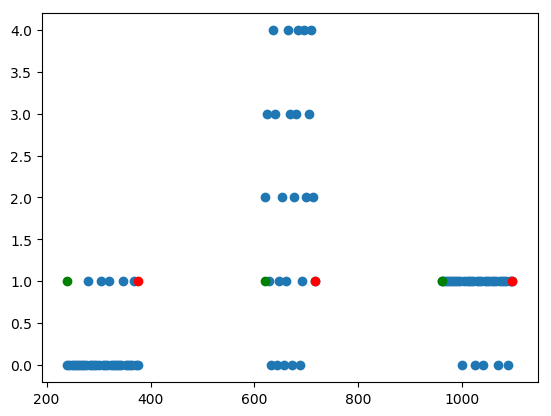

┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall /home/stednitz/.julia/packages/PyCall/L0fLP/src/numpy.jl:67


10-element Vector{Int64}:
  240
  272
  296
  336
  352
  960
  984
 1056
 1072
 1080

In [9]:
scatter(stimtimes,stim_seq)

block_edges = Array{Int64}(undef,3,2)
b_ctr = 1
block_edges[1,1] = stimtimes[1]
block_edges[3,2] = stimtimes[end]
flag = 0
for s = 2:length(stimtimes)-1
    isi_now = stimtimes[s+1]-stimtimes[s]
    if isi_now > isi
        block_edges[b_ctr,2] = stimtimes[s]
        b_ctr+=1
        flag = 1
    end
    if flag == 1 && isi_now == isi
        block_edges[b_ctr,1] = stimtimes[s]
        flag = 0
    end
end

for b = 1:3
    scatter(block_edges[b,1],1,color="green")
    scatter(block_edges[b,2],1,color="red")
end

oddball_times = []
oddball_1st = []
oddball_2nd = []

for i = 1:35
    curr_stim = stim_seq[i]
    if curr_stim == 1
        append!(oddball_times,stimtimes[i])
        append!(oddball_1st,stimtimes[i])
    end
end

for i = length(stimtimes)-35:length(stimtimes)
    curr_stim = stim_seq[i]
    if curr_stim == 0
        append!(oddball_times,stimtimes[i])
        append!(oddball_2nd,stimtimes[i])

    end
end

f1_times = []
f2_times = []
for i = 1:length(stimtimes)
    curr_stim = stim_seq[i]
    if curr_stim == 1
        append!(f2_times,stimtimes[i])
    elseif curr_stim == 0
        append!(f1_times,stimtimes[i])
    end
end

ms_f1_times = []
ms_f2_times = []
ms_f3_times = []
ms_f4_times = []
ms_f5_times = []

for i = findall((stimtimes .>= block_edges[2,1]) .&& (stimtimes .<= block_edges[2,2]))
    curr_stim = stim_seq[i[2]]
    if curr_stim == 1
        append!(ms_f2_times,stimtimes[i])
    elseif curr_stim == 0
        append!(ms_f1_times,stimtimes[i])
    elseif curr_stim == 2
        append!(ms_f3_times,stimtimes[i])
    elseif curr_stim == 3
        append!(ms_f4_times,stimtimes[i])
    elseif curr_stim == 4
        append!(ms_f5_times,stimtimes[i])
    end
end

rng1 = Int(block_edges[1,1]):isi*2:Int(block_edges[1,2])
rng2 = Int(block_edges[3,1]):isi*2:Int(block_edges[3,2])

randtimes = vcat(sort(sample(rng1,5,replace=false)),sort(sample(rng2,5,replace=false)))

r1 = collect(rng1)
rn2 = collect(rng2)
filter!(r1->r1∉oddball_1st,r1)
filter!(rn2->rn2∉oddball_2nd,rn2)

#offset_1 = sort(rand(r1,5))
offset_1 = sort(sample(r1, 5, replace=false))
offset_2 = sort(sample(rn2,5,replace=false))
offset_all = vcat(offset_1,offset_2)

### Compute regressors

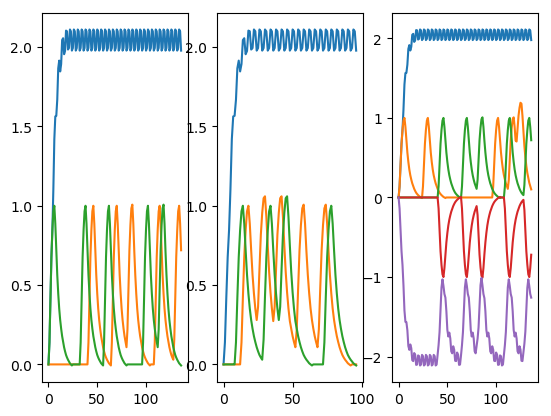

10-element Vector{String}:
 "auditory"
 "oddball"
 "oddball_offset"
 "random"
 "freq1"
 "freq2"
 "ob_1st"
 "ob_2nd"
 "ob_1st_offset"
 "ob_2nd_offset"

In [10]:
function compute_calcium(times)
    reg = zeros((n_frames))
    for stim in times
        nd = stim + length(spike)
        off = 0
        if length(reg) < stim+length(spike) 
            off = nd - length(reg)
            nd = length(reg)
        end
        reg[stim:nd-1] .+= spike[1:end-off]
    end
    return reg
end

auditory_reg = compute_calcium(stimtimes)
oddball_reg = compute_calcium(oddball_times)
oddball_offset_reg = compute_calcium(offset_all)
random_reg = compute_calcium(randtimes)

f1_reg = compute_calcium(f1_times)
f2_reg = compute_calcium(f2_times)

ms_f1_reg = compute_calcium(ms_f1_times)
ms_f2_reg = compute_calcium(ms_f2_times)

ob1_reg = compute_calcium(oddball_1st)
ob2_reg = compute_calcium(oddball_2nd)

ob1_offset_reg = compute_calcium(offset_1)
ob2_offset_reg = compute_calcium(offset_2)

subplot(131)
rng = block_edges[1,1]:block_edges[1,2]
plot(auditory_reg[rng])
plot(oddball_reg[rng])
plot(oddball_offset_reg[rng])

subplot(132)
rng = block_edges[2,1]:block_edges[2,2]
plot(auditory_reg[rng])
plot(f1_reg[rng])
plot(f2_reg[rng])

subplot(133)
rng = block_edges[3,1]:block_edges[3,2]
plot(auditory_reg[rng])
plot(oddball_offset_reg[rng])
plot(oddball_reg[rng])
plot(.-f1_reg[rng])
plot(.-f2_reg[rng])

exp_regs = [auditory_reg,oddball_reg,oddball_offset_reg,random_reg,f1_reg,f2_reg,ob1_reg,ob2_reg,ob1_offset_reg,ob2_offset_reg]#,motion_reg]
reg_titles = ["auditory","oddball","oddball_offset","random","freq1","freq2","ob_1st","ob_2nd","ob_1st_offset","ob_2nd_offset"]#,"motion"]

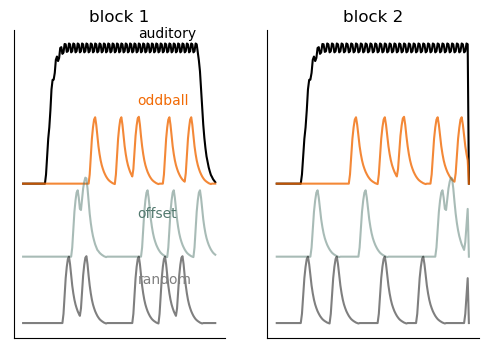

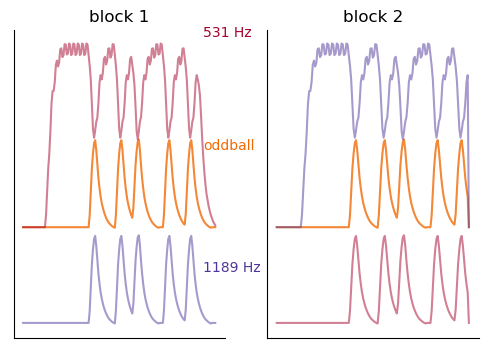

Any[]

In [11]:
figure(figsize=(6,4))

ax = subplot(121); title("block 1")
rng = block_edges[1,1]-fps*5:block_edges[1,2]+fps*5
plot(auditory_reg[rng],color="black")
plot(oddball_reg[rng],color=colors[1],alpha=0.8)
plot(oddball_offset_reg[rng].-1.1,color=colors[2],alpha=0.5)
plot(random_reg[rng].-2.1,color="black",alpha=0.5)
ax.spines["top"].set_visible(false)
ax.spines["right"].set_visible(false)
ax.set_yticks([]); ax.set_xticks([])
xpos = 105
text(xpos,2.2,"auditory",color="black")
text(xpos,1.2,"oddball",color=colors[1])
text(xpos,-0.5,"offset",color=colors[2])
text(xpos,-1.5,"random",color="gray")

ax = subplot(122); title("block 2")
rng = block_edges[3,1]-fps*5:n_frames
plot(auditory_reg[rng],color="black")
plot(oddball_reg[rng],color=colors[1],alpha=0.8)
plot(oddball_offset_reg[rng].-1.1,color=colors[2],alpha=0.5)
plot(random_reg[rng].-2.1,color="black",alpha=0.5)
ax.spines["top"].set_visible(false)
ax.spines["right"].set_visible(false)
ax.set_yticks([]); ax.set_xticks([])

figure(figsize=(6,4))

ax = subplot(121); title("block 1")
rng = block_edges[1,1]-fps*5:block_edges[1,2]+fps*5
#plot(auditory_reg[rng],color="black")
plot(oddball_reg[rng],color=colors[1],alpha=0.8)
plot(f1_reg[rng],color=colors[3],alpha=0.5)
plot(f2_reg[rng].-1.1,color=colors[4],alpha=0.5)
ax.spines["top"].set_visible(false)
ax.spines["right"].set_visible(false)
ax.set_yticks([]); ax.set_xticks([])
xpos = 165
text(xpos,2.2,"531 Hz",color=colors[3])
text(xpos,0.9,"oddball",color=colors[1])
text(xpos,-0.5,"1189 Hz",color=colors[4])
#text(xpos,-1.5,"random",color=colors[4])

ax = subplot(122); title("block 2")
rng = block_edges[3,1]-fps*5:n_frames
plot(oddball_reg[rng],color=colors[1],alpha=0.8)
plot(f2_reg[rng],color=colors[4],alpha=0.5)
plot(f1_reg[rng].-1.1,color=colors[3],alpha=0.5)
ax.spines["top"].set_visible(false)
ax.spines["right"].set_visible(false)
ax.set_yticks([]); ax.set_xticks([])

In [11]:
exp_regs = [auditory_reg,oddball_reg,oddball_offset_reg,random_reg,f1_reg,f2_reg,ob1_reg,ob2_reg,ob1_offset_reg,ob2_offset_reg]#,motion_reg]

10-element Vector{Vector{Float64}}:
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  2.0995526962383515, 1.978030190476769, 1.9943201006071474, 2.111279517549821, 2.0995526962383515, 1.978030190476769, 1.9943201006071474, 2.111279517549821, 2.0995526962383515, 0.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.6762969962076263, 0.8407451503692365, 0.9652729118260452, 1.0, 0.8868389098895824, 0.71948580820054, 0.5647033442172837, 0.446770218024352, 0.35194455097519445, 0.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.39525610041916104, 0.3093799245516953, 0.24353262746714446, 0.1851822200988767, 0.14121935957081472, 0.10165325774464913, 0.08224160391132143, 0.05964541037939694, 0.043311549443966584, 0.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.13856961318535252, 0.41968166904719506, 0.6762383263587934, 0.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.6762969962076263, 0.8407451503692365, 0.96527291

### Read in the data if you already have it

In [12]:
short_id = file_list[pnum][length(drv)+17:end-4]
outfile = outpath*short_id*".h5"

of = h5open(outfile,"r")
coeffs = Array{Float32}(undef,length(exp_regs),total_rois); fill!(coeffs,NaN)
r2s = Array{Float32}(undef,length(exp_regs),total_rois); fill!(r2s,NaN)
pvals = Array{Float32}(undef,length(exp_regs),total_rois); fill!(pvals,NaN)
sig_rois = Array{Int64}[]
nonsig_rois = Array{Int64}[]

for r=1:length(exp_regs)
    exp_regs[r] = of[reg_titles[r]]["reg"][]
    #temp = of[reg_titles[r]]["r2"][]
    r2s[r,:] .= of[reg_titles[r]]["r2"][]
    coeffs[r,:] .= of[reg_titles[r]]["coef"][]
    pvals[r,:] .= of[reg_titles[r]]["pval"][]
    push!(sig_rois, of[reg_titles[r]]["sig_rois"][])
    push!(nonsig_rois, of[reg_titles[r]]["nonsig_rois"][])
end
close(of)

In [ ]:
[259,260,261,262,263,278,294,990,1086]

### Detect significant ROIs (p < .001/total ROIs && R^2 > 99th percentile)

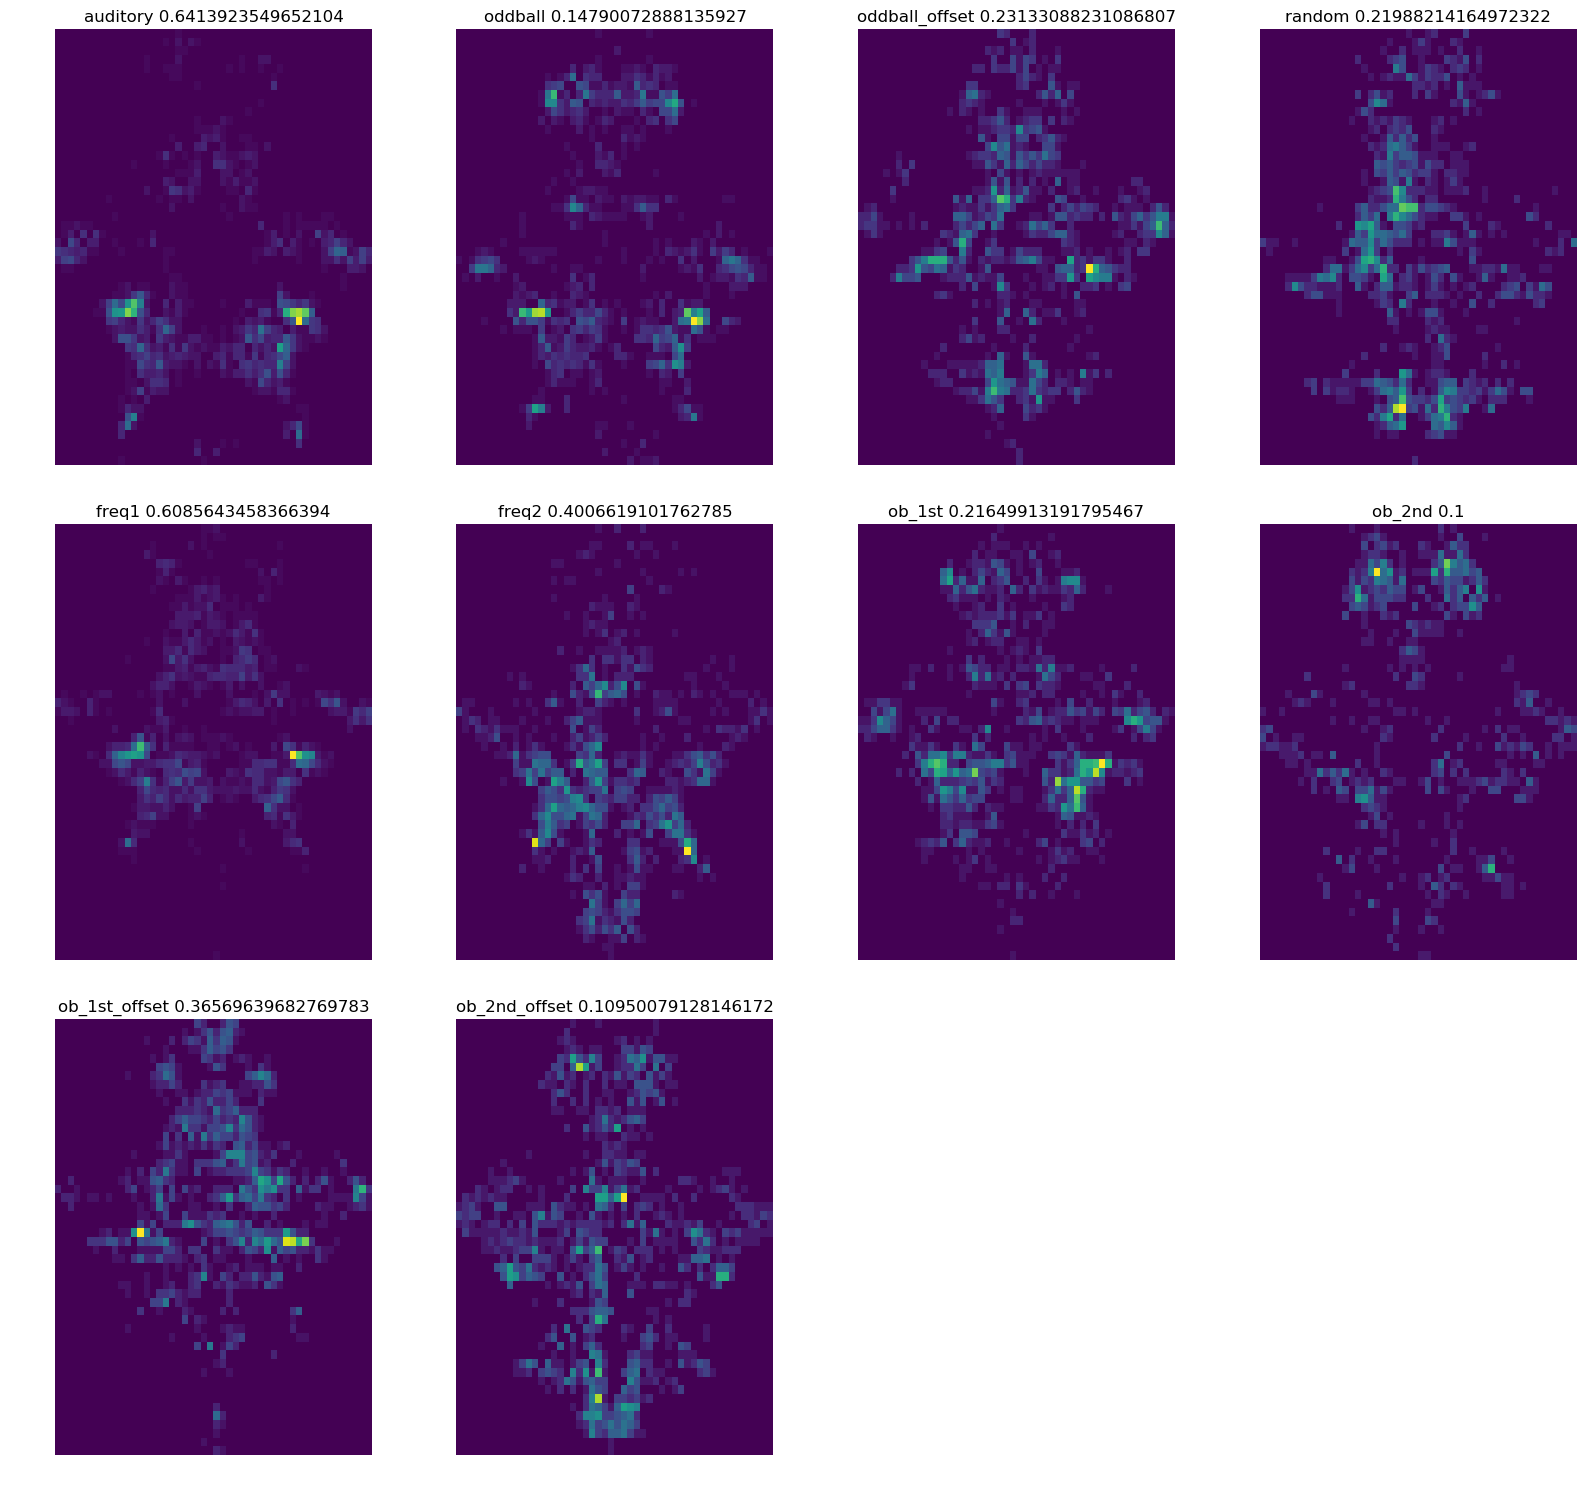

In [13]:
sig_rois = Array{Int64}[]
nonsig_rois = Array{Int64}[]

rows,cols=3,4
figure(figsize=(cols*4,rows*5)); 

alpha_cutoff = 0.001/total_rois
minimum_r2 = 0.1
perc_cutoff = 99
for r=1:length(exp_regs)
    pvals_clean = pvals[r,:]
    sig_roi_pval = findall(pvals_clean .< alpha_cutoff); #idx_rest_pval = findall(pvals_clean .>= alpha_cutoff)
    
    r2s_clean = replace(r2s[r,:],NaN=>0)
    perc_99 = percentile(r2s_clean,perc_cutoff)
    if perc_99 < minimum_r2 perc_99 = minimum_r2 end
    
    sig_roi_r2 = findall(r2s_clean .> perc_99); #idx_rest_r2 = findall(r2s_clean .<= percentile(r2s_clean,perc_99))
    
    sig_roi = intersect(sig_roi_pval,sig_roi_r2)
    nonsig_roi = collect(1:total_rois)
    deleteat!(nonsig_roi,sig_roi[1])

    push!(sig_rois,sig_roi)
    push!(nonsig_rois,nonsig_roi)
    subplot(rows,cols,r)
    title(reg_titles[r]*" $perc_99")
    plt.hist2d(centroids[sig_roi,2],centroids[sig_roi,1],bins=50); axis("off");
end

tight_layout()

### Exclude overlapping ROIs

In [14]:
no_overlap_sig = Array{Int64}[]
no_overlap_nonsig = Array{Int64}[]

exclude = copy(unique(vcat(sig_rois[9,:][1],sig_rois[10,:][1],sig_rois[5,:][1],sig_rois[6,:][1])))

for i in [7,8]
    sr = copy(sig_rois[i,:][1])
    del_idx = []
    for s = 1:length(sr)
        if (sr[s] in exclude) == true
            append!(del_idx,s)
        end
    end
    
    deleteat!(sr,del_idx)
    nonsig_roi = collect(1:total_rois)
    deleteat!(nonsig_roi,sr)
    
    push!(no_overlap_sig,sr)
    push!(no_overlap_nonsig,nonsig_roi)
    
    push!(sig_rois,sr)
    push!(nonsig_rois,sr)
end

In [15]:
n_fish = length(unique(idx_fish))

12

In [16]:
using PyCall
@pyimport matplotlib.colors as matcolors

cool_cmap = matcolors.LinearSegmentedColormap.from_list("cool", (
                 (0.000, (.996, .945, .894)),
                 (0.250, (0.914, 0.416, 0.165)),
                 (0.500, (0.605, 0.106, 0.784)),
                 (0.750, (0.04, 0.490, 0.486)),
                 (1.000, (0, 0, 0))))

In [17]:
using PyCall
@pyimport matplotlib.colors as matcolors

bwr_black = matcolors.LinearSegmentedColormap.from_list("bwr_black", (
                 (0.000, (0.298, 0.443, 1.000)),
                 (0.250, (0.000, 0.145, 0.702)),
                 (0.500, (0.000, 0.000, 0.000)),
                 (0.750, (0.780, 0.012, 0.051)),
                 (1.000, (0.988, 0.290, 0.325))))

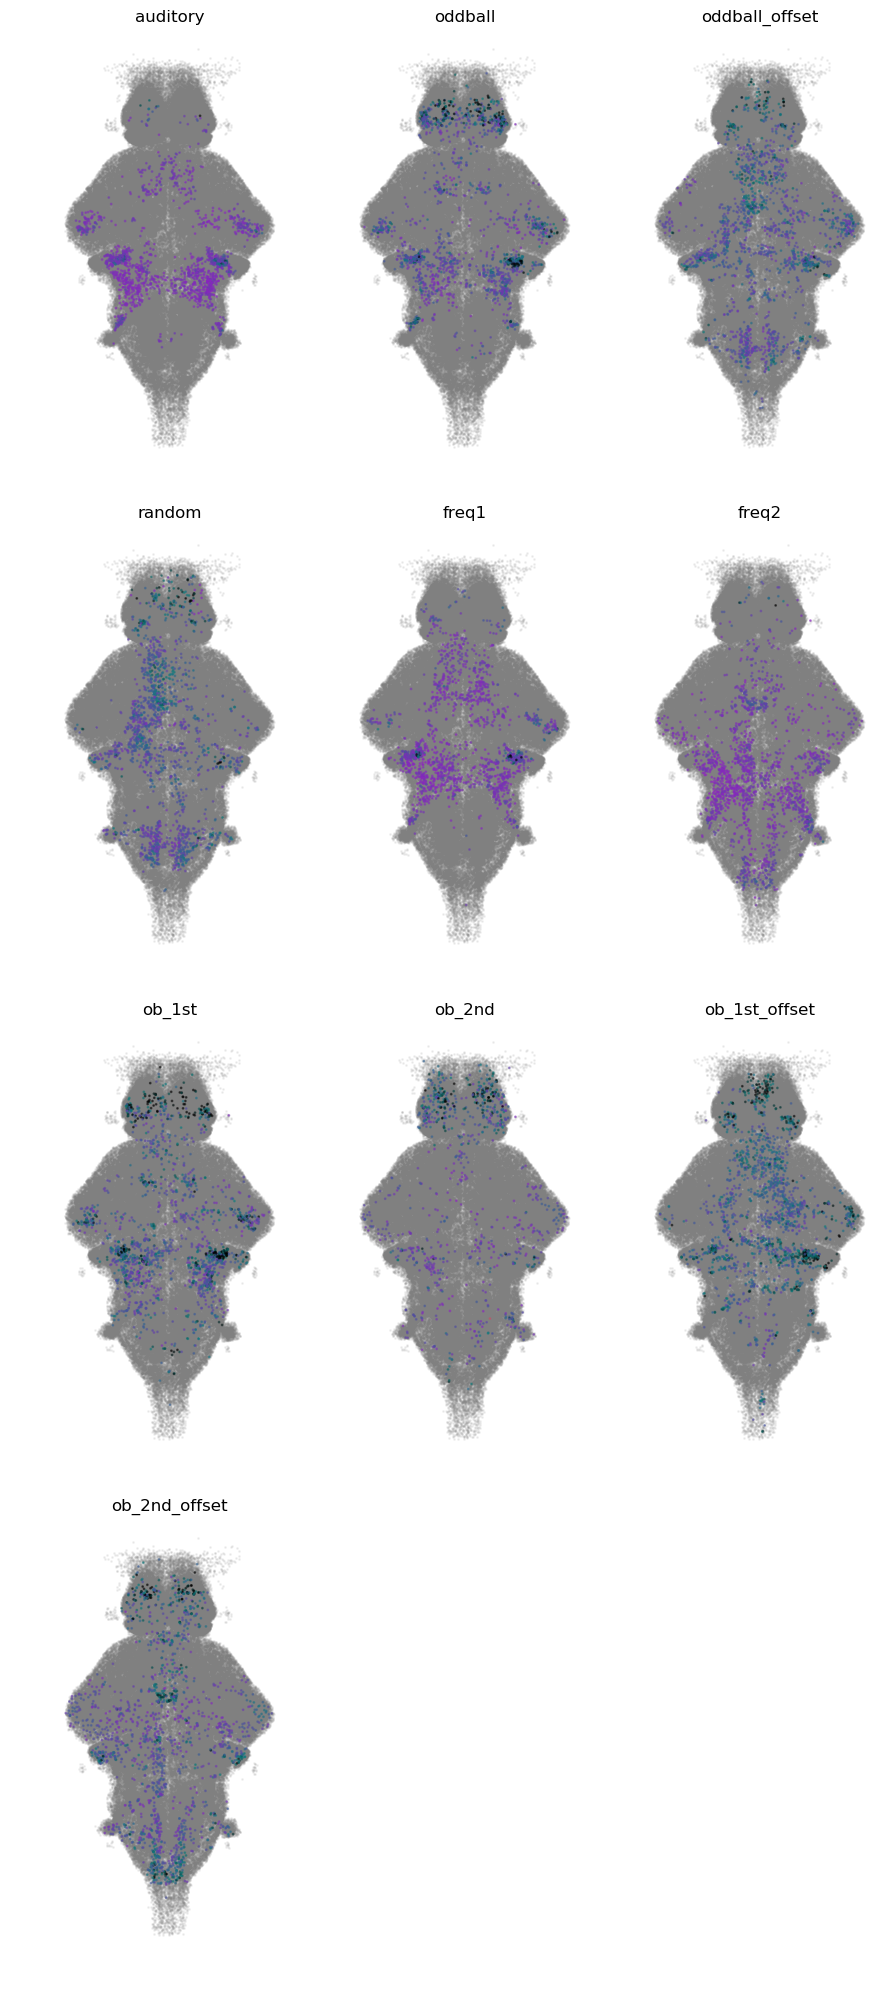

In [17]:
rows,cols=4,3
figure(figsize=(cols*3,rows*5)); 

r=1
for r=1:length(exp_regs)
    sr = sig_rois[r,:][1]
    nr = nonsig_rois[r,:][1]
    subplot(rows,cols,r); axis("off")
    title(reg_titles[r])
    co = (coeffs[r,sr])
    scatter(centroids[nr,2],centroids[nr,1],color="gray",s=1,alpha=0.1)
    scatter(centroids[sr,2],centroids[sr,1],c=co,cmap=cool_cmap,s=1,alpha=0.5,vmin=-0.3,vmax=0.3)
end

tight_layout()

## Anatomy plots

### Oddball/offset

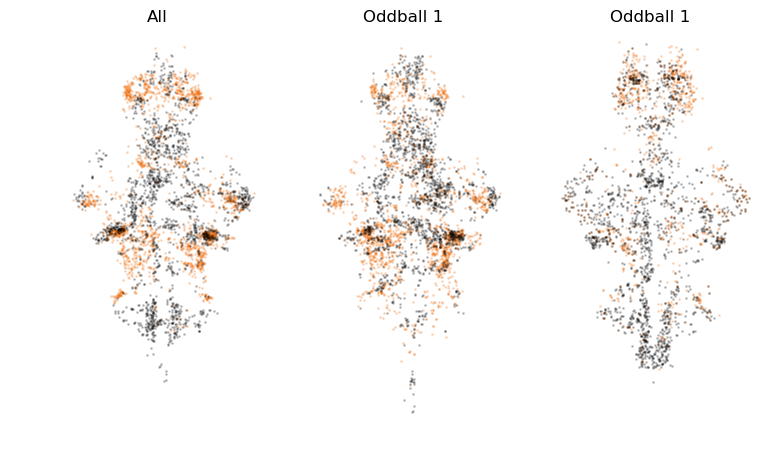

In [618]:
figure(figsize=(9,5)); 
#suptitle("1s ISI")
a = 0.2

titles = ["All","Oddball 1","Oddball 1","Merge"]


sr1 = sig_rois[2,:][1]
nr1 = nonsig_rois[2,:][1]
nr2 = nonsig_rois[7,:][1]
sr2 = sig_rois[7,:][1]
nr3 = nonsig_rois[8,:][1]
sr3 = sig_rois[8,:][1]

osr1 = sig_rois[3,:][1]
onr1 = nonsig_rois[3,:][1]
onr2 = nonsig_rois[9,:][1]
osr2 = sig_rois[9,:][1]
onr3 = nonsig_rois[10,:][1]
osr3 = sig_rois[10,:][1]

ax1 = subplot(131); 
#scatter(centroids[nr1,2],centroids[nr1,1],color="lightgray",s=1,alpha=nsa)
scatter(centroids[sr1,2],centroids[sr1,1],color=colors[1],s=1,alpha=a)
scatter(centroids[osr1,2],centroids[osr1,1],color="black",s=1,alpha=a)

ax2 = subplot(132);
scatter(centroids[sr2,2],centroids[sr2,1],color=colors[1],s=1,alpha=a)
scatter(centroids[osr2,2],centroids[osr2,1],color="black",s=1,alpha=a)

ax3 = subplot(133);
scatter(centroids[sr3,2],centroids[sr3,1],color=colors[1],s=1,alpha=a)
scatter(centroids[osr3,2],centroids[osr3,1],color="black",s=1,alpha=a)

ctr = 1
for ax in [ax1,ax2,ax3]
    ax.set_ylim(ymn,ymx)
    ax.set_xlim(xmn,xmx)
    ax.axis("off")
    ax.set_title(titles[ctr])
    ctr+=1
end

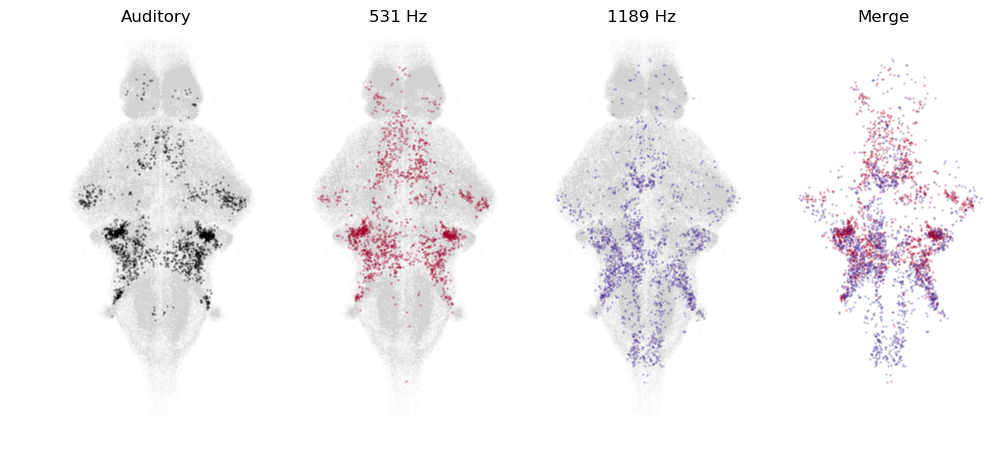

In [619]:
figure(figsize=(12,5)); 
#suptitle("1s ISI")
a = 0.2

titles = ["Auditory","531 Hz","1189 Hz","Merge"]

sr1 = sig_rois[1,:][1]
nr1 = nonsig_rois[1,:][1]
nr2 = nonsig_rois[5,:][1]
sr2 = sig_rois[5,:][1]
nr3 = nonsig_rois[6,:][1]
sr3 = sig_rois[6,:][1]

ax1 = subplot(141); 
scatter(centroids[nr1,2],centroids[nr1,1],color="lightgray",s=1,alpha=nsa)
scatter(centroids[sr1,2],centroids[sr1,1],color="black",s=1,alpha=a)

ax2 = subplot(142);
scatter(centroids[nr2,2],centroids[nr2,1],color="lightgray",s=1,alpha=nsa)
scatter(centroids[sr2,2],centroids[sr2,1],color=colors[3],s=1,alpha=a)

ax3 = subplot(143);
scatter(centroids[nr3,2],centroids[nr3,1],color="lightgray",s=1,alpha=nsa)
scatter(centroids[sr3,2],centroids[sr3,1],color=colors[4],s=1,alpha=a)

ax4 = subplot(144);
scatter(centroids[sr2,2],centroids[sr2,1],color=colors[3],s=1,alpha=a)
scatter(centroids[sr3,2],centroids[sr3,1],color=colors[4],s=1,alpha=a)
#scatter(centroids[sr1,2],centroids[sr1,1],color=colors[1],s=1,alpha=a)

ctr = 1
for ax in [ax1,ax2,ax3,ax4]
    ax.set_ylim(ymn,ymx)
    ax.set_xlim(xmn,xmx)
    ax.axis("off")
    ax.set_title(titles[ctr])
    ctr+=1
end

### Reset fish indices

In [114]:
fish_list = unique(idx_fish)
n_fish = length(fish_list)
reset_idx = collect(1:n_fish)

reset_idx_fish = copy(idx_fish)
for i in 1:length(idx_fish)
    loc = findall(idx_fish[i] .== fish_list)[1]
    reset_idx_fish[i] = Int.(reset_idx[loc])
end

## Z Brain masks

In [18]:
mask_f = matopen(drv*"masks/Zbrain_Masks.mat","r")
masks=read(mask_f,"Zbrain_Masks")
close(mask_f)

In [19]:
regions_f = matopen(drv*"masks/1sISI_regions.mat","r")
keys(regions_f)
per_brain_regions = read(regions_f,"PerBrainRegions")
region_list = vec(read(regions_f,"RegionList"))

12-element Vector{Any}:
 "Thalamus"
 "Cerebellum"
 "Semicircularis"
 "Telencephalon"
 "Tectum"
 "Tegmentum"
 "Habenula"
 "Pretectum"
 "MON"
 "Hindbrain"
 "Raphe_Superior"
 "Interpeduncular_Nucleus"

In [25]:
tel_f = matopen(drv*"masks/1sISI_telencephalon_regions.mat","r")
keys(tel_f)
per_tel_regions = read(tel_f,"TelBrainRegions")
tel_region_list = sort(vec(read(tel_f,"Tel_RegionList")))
tel_idx_list = sort(collect(keys(per_tel_regions)))



19-element Vector{String}:
 "Anterior_Commisure"
 "Isl1_cluster_1"
 "Isl1_cluster_2"
 "Olfactory_Bulb"
 "Olfactory_bulb_dopaminergic_neuron_areas"
 "Olig2_Cluster"
 "Optic_Commissure"
 "Pallium"
 "Postoptic_Commissure"
 "S1181t_Cluster"
 "Subpallial_Gad1b_cluster"
 "Subpallial_Otpb_Cluster_2"
 "Subpallial_Otpb_strip"
 "Subpallial_Vglut2_Cluster"
 "Subpallial_dopaminergic_cluster"
 "Subpallium"
 "Telencephalic_Migrated_Area_4__M4_"
 "Vglut2_rind"
 "Vmat2_cluster"

In [21]:
tel_idx_list = ["Anterior_Commisure","Isl1_cluster_1","Isl1_cluster_2","Olfactory_Bulb","Olfactory_bulb_dopaminergic_neuron_areas","Olig2_Cluster","Optic_Commissure","Pallium","Postoptic_Commissure","S1181t_Cluster","Subpallial_Gad1b_cluster","Subpallial_Otpb_Cluster_2","Subpallial_Otpb_strip","Subpallial_Vglut2_Cluster","Subpallial_dopaminergic_cluster","Subpallium","Telencephalic_Migrated_Area_4_(M4)","Vglut2_rind","Vmat2_cluster"]

19-element Vector{String}:
 "Anterior_Commisure"
 "Isl1_cluster_1"
 "Isl1_cluster_2"
 "Olfactory_Bulb"
 "Olfactory_bulb_dopaminergic_neuron_areas"
 "Olig2_Cluster"
 "Optic_Commissure"
 "Pallium"
 "Postoptic_Commissure"
 "S1181t_Cluster"
 "Subpallial_Gad1b_cluster"
 "Subpallial_Otpb_Cluster_2"
 "Subpallial_Otpb_strip"
 "Subpallial_Vglut2_Cluster"
 "Subpallial_dopaminergic_cluster"
 "Subpallium"
 "Telencephalic_Migrated_Area_4_(M4)"
 "Vglut2_rind"
 "Vmat2_cluster"

In [22]:
n_fish = length(unique(idx_fish))
n_frames = size(DF)[2]

1100

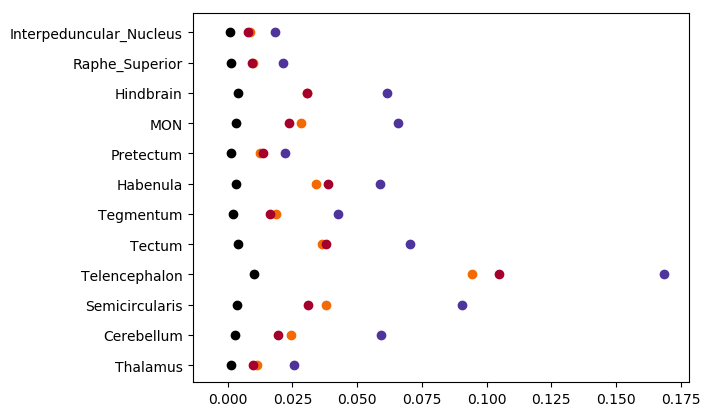

(PyObject[PyObject <matplotlib.axis.YTick object at 0x7f3695de9828>, PyObject <matplotlib.axis.YTick object at 0x7f3695de9978>, PyObject <matplotlib.axis.YTick object at 0x7f36954357f0>, PyObject <matplotlib.axis.YTick object at 0x7f36954201d0>, PyObject <matplotlib.axis.YTick object at 0x7f3695420828>, PyObject <matplotlib.axis.YTick object at 0x7f3695420e80>, PyObject <matplotlib.axis.YTick object at 0x7f369540c7f0>, PyObject <matplotlib.axis.YTick object at 0x7f36952a5860>, PyObject <matplotlib.axis.YTick object at 0x7f36952a5ef0>, PyObject <matplotlib.axis.YTick object at 0x7f36952ac5c0>, PyObject <matplotlib.axis.YTick object at 0x7f36952acc50>, PyObject <matplotlib.axis.YTick object at 0x7f36952b2320>], PyObject[PyObject Text(0,1,'Thalamus'), PyObject Text(0,2,'Cerebellum'), PyObject Text(0,3,'Semicircularis'), PyObject Text(0,4,'Telencephalon'), PyObject Text(0,5,'Tectum'), PyObject Text(0,6,'Tegmentum'), PyObject Text(0,7,'Habenula'), PyObject Text(0,8,'Pretectum'), PyObject Te

In [21]:
#rows,cols = 3,4
#figure(figsize=(cols*1.5,rows*2.5))
    df_avg = []
 
for r = 1:12
    curr_region = region_list[r]
    idx = Int.(per_brain_regions[curr_region]["idx"])
    
    df_avg = []
    for t in stimtimes
        df_resp = maximum(DF[idx,t:t+isi].-DF[idx,t])
       push!(df_avg,df_resp)
    end
    scatter((mean(df_avg)./length(stimtimes)),r,color="black")
    
    df_avg = []
    for t in oddball_times
        df_resp = maximum(DF[idx,t:t+isi].-DF[idx,t])
       push!(df_avg,df_resp)
    end
    scatter((mean(df_avg)./length(oddball_times)),r,color=colors[1])
    
    df_avg = []
    for t in oddball_1st
        df_resp = maximum(DF[idx,t:t+isi].-DF[idx,t])
        push!(df_avg,df_resp)
    end
    scatter((mean(df_avg)./length(oddball_1st)),r,color=colors[4])
    
    df_avg = []
    for t in oddball_2nd
        df_resp = maximum(DF[idx,t:t+isi].-DF[idx,t])
       push!(df_avg,df_resp)
    end
    scatter((mean(df_avg)./length(oddball_times)),r,color=colors[3])
end

yticks(collect(1:12),region_list)


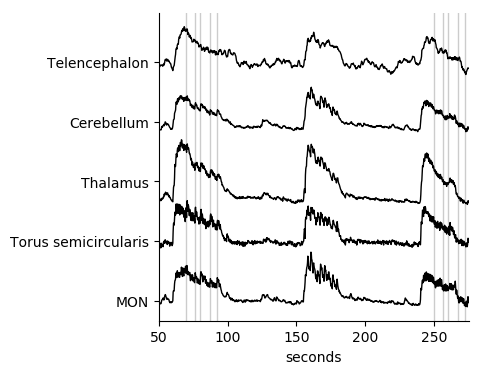

PyObject Text(0.5,24,'seconds')

In [34]:
df_avg = []

figure(figsize=(4,4))
ax = subplot(111)
x = collect(1:n_frames)./fps
sub = [9,3,1,2,4]
sub_list = ["MON","Torus semicircularis","Thalamus","Cerebellum","Telencephalon"]
ctr = 1
for r in sub
    curr_region = region_list[r]
    idx = Int.(per_brain_regions[curr_region]["idx"])
    avg = vec(mean(DF[idx,:],dims=1))
    stdev = vec(std(DF[idx,:],dims=1))./n_fish
    plot(x,(avg.-avg[1]).+ctr*0.05,color="black",linewidth=1)
    ctr+=1
end

yticks(collect(1:length(sub)).*0.05,sub_list)
ax.spines["top"].set_visible(false)
ax.spines["right"].set_visible(false)
for ob in oddball_times
    ax.axvline(ob/fps,0,1,color="black",linewidth=1,alpha=0.2)
end
xlim(50,n_frames/fps)
xlabel("seconds")

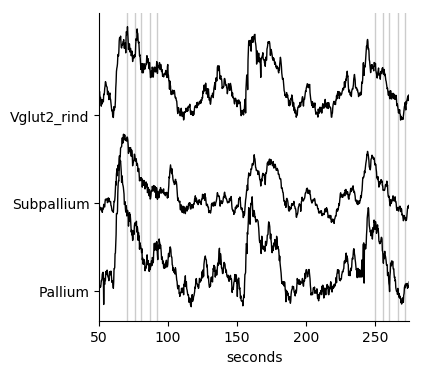

PyObject Text(0.5,24,'seconds')

In [39]:
df_avg = []

figure(figsize=(4,4))
ax = subplot(111)
x = collect(1:n_frames)./fps

ctr = 1
sub = collect(1:length(tel_idx_list))
sub_list = tel_idx_list

sub = [8,16,18]
sub_list = tel_idx_list[sub]

for r = 1:length(sub)
    curr_region = tel_idx_list[r]
    idx = Int.(per_tel_regions[curr_region]["idx"])
    avg = vec(mean(DF[idx,:],dims=1))
    stdev = vec(std(DF[idx,:],dims=1))./n_fish
    plot(x,(avg.-avg[1]).+ctr*0.05,color="black",linewidth=1)
    ctr+=1
end

yticks(collect(1:length(sub)).*0.05,sub_list)
ax.spines["top"].set_visible(false)
ax.spines["right"].set_visible(false)
for ob in oddball_times
    ax.axvline(ob/fps,0,1,color="black",linewidth=1,alpha=0.2)
end
xlim(50,n_frames/fps)
xlabel("seconds")

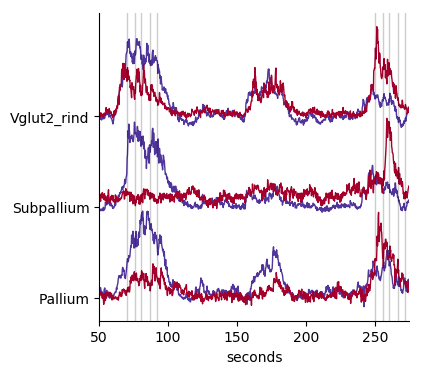

PyObject Text(0.5,24,'seconds')

In [27]:
df_avg = []

figure(figsize=(4,4))
ax = subplot(111)
x = collect(1:n_frames)./fps

ctr = 1
sub = collect(1:length(tel_idx_list))
sub_list = tel_idx_list

sub = [8,16,18]
sub_list = tel_idx_list[sub]

for r = 1:length(sub)
    curr_region = tel_idx_list[r]
    idx = intersect(Int.(per_tel_regions[curr_region]["idx"]),sig_rois[11])
    avg = vec(mean(DF[idx,:],dims=1))
    stdev = vec(std(DF[idx,:],dims=1))./n_fish
    val = (avg.-avg[1])./maximum(avg)
    plot(x,val.+ctr,color=colors[4],linewidth=1)
    
    idx = intersect(Int.(per_tel_regions[curr_region]["idx"]),sig_rois[12])
    avg = vec(mean(DF[idx,:],dims=1))
    stdev = vec(std(DF[idx,:],dims=1))./n_fish
    val = (avg.-avg[1])./maximum(avg)
    plot(x,val.+ctr,color=colors[3],linewidth=1)
    ctr+=1
end

yticks(collect(1:length(sub)),sub_list)
ax.spines["top"].set_visible(false)
ax.spines["right"].set_visible(false)
for ob in oddball_times
    ax.axvline(ob/fps,0,1,color="black",linewidth=1,alpha=0.2)
end
xlim(50,n_frames/fps)
xlabel("seconds")

In [23]:
r = sub[1]

curr_region = tel_idx_list[r]
    idx = intersect(Int.(per_tel_regions[curr_region]["idx"]),sig_rois[11])
    avg = vec(nanmean(DF[idx,:],dims=1))
    stdev = vec(std(DF[idx,:],dims=1))./n_fish
    val = (avg.-avg[1])./maximum(avg)
    plot(x,val.+ctr,color=colors[4],linewidth=1)
    
    idx = intersect(Int.(per_tel_regions[curr_region]["idx"]),sig_rois[12])

LoadError: UndefVarError: sub not defined

In [37]:
df_avg = []

rows,cols = 5,4
figure(figsize=(cols*2,rows*2))
x = collect(1:n_frames)./fps

ctr = 1
sub = collect(1:length(tel_idx_list))

ob = 11

sub_list = tel_idx_list


#ylim(1000,ymx)

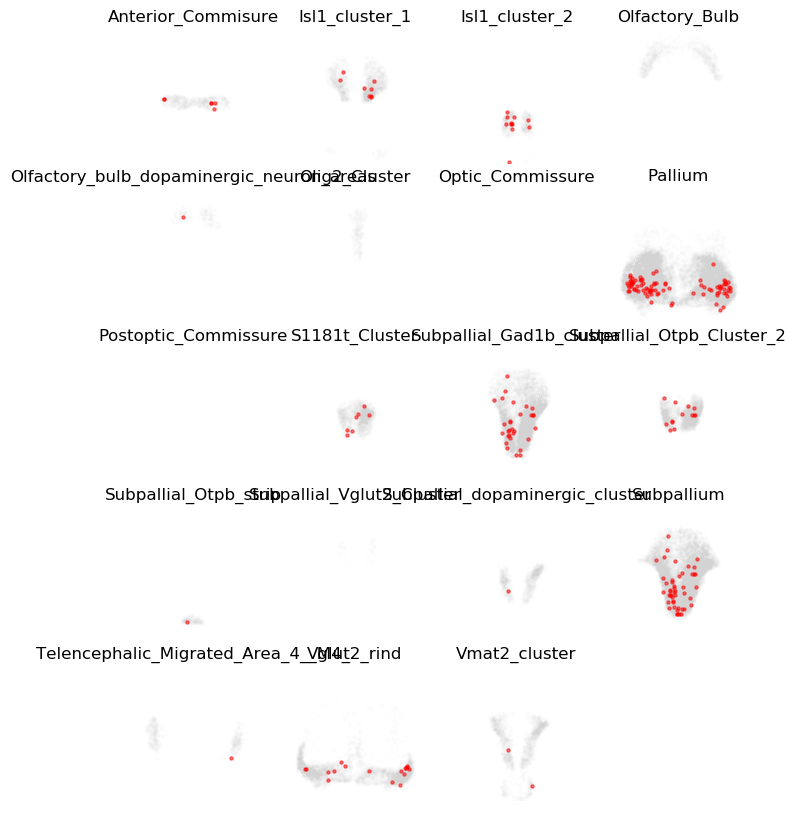

Anterior_Commisure: 0.023809523809523808
Isl1_cluster_1: 0.031746031746031744
Isl1_cluster_2: 0.04365079365079365
Olfactory_Bulb: 0.0
Olfactory_bulb_dopaminergic_neuron_areas: 0.003968253968253968
Olig2_Cluster: 0.007936507936507936
Optic_Commissure: 0.0
Pallium: 0.3531746031746032
Postoptic_Commissure: 0.0
S1181t_Cluster: 0.09126984126984126
Subpallial_Gad1b_cluster: 0.11904761904761904
Subpallial_Otpb_Cluster_2: 0.051587301587301584
Subpallial_Otpb_strip: 0.003968253968253968
Subpallial_Vglut2_Cluster: 0.0
Subpallial_dopaminergic_cluster: 0.003968253968253968
Subpallium: 0.1865079365079365
Telencephalic_Migrated_Area_4__M4_: 0.003968253968253968
Vglut2_rind: 0.06746031746031746
Vmat2_cluster: 0.007936507936507936


In [38]:
df_avg = []

rows,cols = 5,4
figure(figsize=(cols*2,rows*2))
x = collect(1:n_frames)./fps

ctr = 1
sub = collect(1:length(tel_idx_list))

ob = 11

sub_list = tel_idx_list


idx_tel = []
for r = 1:length(sub)
    curr_region = tel_idx_list[r]
    idx2 = intersect(Int.(per_tel_regions[curr_region]["idx"]),sig_rois[ob])
    idx_tel = vcat(idx_tel,idx2)
end


for r = 1:length(sub)
    subplot(rows,cols,r); axis("off"); title(sub_list[r])
    curr_region = tel_idx_list[r]
    idx = Int.(per_tel_regions[curr_region]["idx"])
    scatter(centroids[idx,2],centroids[idx,1],s=5,alpha=nsa,color="lightgrey")
    idx2 = intersect(Int.(per_tel_regions[curr_region]["idx"]),sig_rois[ob])
    scatter(centroids[idx2,2],centroids[idx2,1],s=5,alpha=0.5,color="red")
    
    ylim(1050,ymx)
    xlim(170,460);
    print(sub_list[r],": ",length(idx2)./length(idx_tel),"\n")
end

#ylim(1000,ymx)

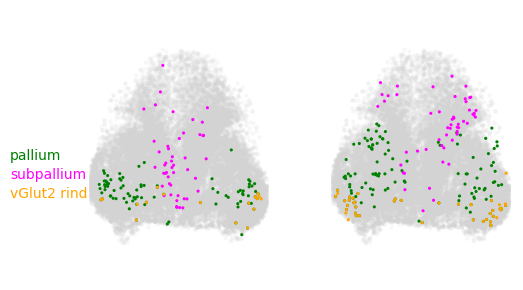

Pallium: 0.5816993464052288
Subpallium: 0.30718954248366015
Vglut2_rind: 0.1111111111111111
Pallium: 0.5869565217391305
Subpallium: 0.23043478260869565
Vglut2_rind: 0.1826086956521739


In [85]:
sub = [8,16,18]

col2 = ["green","magenta","orange"]


figure(figsize=(5,3))

ax1 = subplot(121); axis("off")
text(80,1150,"pallium",color=col2[1])
text(80,1130,"subpallium",color=col2[2])
text(80,1110,"vGlut2 rind",color=col2[3])

ax2 = subplot(122); axis("off")

ob = 11
sub_list = tel_idx_list[sub]
ctr =1
for ob = [11,12]
    subplot(1,2,ctr)
    idx_tel = []
    for r = 1:length(sub)
        curr_region = sub_list[r]
        idx2 = intersect(Int.(per_tel_regions[curr_region]["idx"]),sig_rois[ob])
        idx_tel = vcat(idx_tel,idx2)
    end

    for r = 1:length(sub)
        #subplot(rows,cols,r); axis("off"); title(sub_list[r])
        curr_region = sub_list[r]
        idx = Int.(per_tel_regions[curr_region]["idx"])
        scatter(centroids[idx,2],centroids[idx,1],s=5,alpha=0.1,color="lightgrey",zorder=1)
        idx2 = intersect(Int.(per_tel_regions[curr_region]["idx"]),sig_rois[ob])
        scatter(centroids[idx2,2],centroids[idx2,1],s=5,alpha=1,color=col2[r],edgecolor="none",zorder=2)

        ylim(1050,ymx)
        xlim(190,440);
        print(sub_list[r],": ",length(idx2)./length(idx_tel),"\n")
    end
    ctr+=1
end

tight_layout()

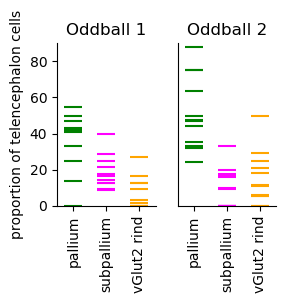

11 1 0.425531914893617 20 684
11 2 0.0851063829787234 4 684
11 3 0.1276595744680851 6 684
11 1 0.4117647058823529 7 56
11 2 0.17647058823529413 3 56
11 3 0.0 0 56
11 1 0.46875 15 46
11 2 0.125 4 46
11 3 0.09375 3 46
11 1 0.5 4 51
11 2 0.125 1 51
11 3 0.125 1 51
11 1 0.3333333333333333 2 23
11 2 0.16666666666666666 1 23
11 3 0.16666666666666666 1 23
11 1 0.25 1 58
11 2 0.25 1 58
11 3 0.0 0 58
11 1 0.4107142857142857 23 250
11 2 0.21428571428571427 12 250
11 3 0.017857142857142856 1 250
11 1 NaN 0 5
11 2 NaN 0 5
11 3 NaN 0 5
11 1 0.5454545454545454 6 36
11 2 0.09090909090909091 1 36
11 3 0.2727272727272727 3 36
11 1 0.0 0 21
11 2 0.4 2 21
11 3 0.0 0 21
11 1 0.42857142857142855 3 11
11 2 0.14285714285714285 1 11
11 3 0.0 0 11
11 1 0.13559322033898305 8 145
11 2 0.288135593220339 17 145
11 3 0.03389830508474576 2 145
12 1 0.35403726708074534 57 171
12 2 0.19875776397515527 32 171
12 3 0.055900621118012424 9 171
12 1 0.75 3 22
12 2 0.0 0 22
12 3 0.0 0 22
12 1 0.47368421052631576 9 36
12 2 0

In [99]:
sub = [8,16,18]

col2 = ["green","magenta","orange"]


figure(figsize=(3,3))

ax1 = subplot(121); ylabel("proportion of telencephalon cells"); title("Oddball 1")
ax2 = subplot(122); ax2.set_yticks([]); title("Oddball 2")
sub_list = tel_idx_list[sub]
sp_ctr = 0
for ob = [11,12]
    sp_ctr +=1
    subplot(1,2,sp_ctr)
    for fish in unique(idx_fish)
        valid_idx = findall(idx_fish[1,:] .== fish)
        sr = intersect(valid_idx,sig_rois[ob])
        idx_tel = []
        for r = 1:length(tel_idx_list)
            curr_region = tel_idx_list[r]
            idx2 = intersect(Int.(per_tel_regions[curr_region]["idx"]),sr)
            idx_tel = vcat(idx_tel,idx2)
        end
        
        ctr =1
        for r = 1:length(sub)
            curr_region = sub_list[r]
            idx = Int.(per_tel_regions[curr_region]["idx"])
            idx2 = intersect(idx,sr)
            val = length(idx2)/length(idx_tel)
            scatter(r,val*100,color=col2[ctr],marker="_",s=150)
            print("$ob $r $val ",length(idx2)," ",length(sr),"\n")
            ctr+=1
        end
    end
end

for ax in [ax1,ax2]
    ax.set_ylim(0,90)
    ax.set_xticks([1,2,3])
    ax.set_xticklabels(["pallium","subpallium","vGlut2 rind"],rotation=90)
    ax.set_xlim(0.5,3.5)
    ax.spines["top"].set_visible(false)
    ax.spines["right"].set_visible(false)
end

tight_layout()

In [ ]:
    for fish in unique(idx_fish)
        valid_idx = findall(idx_fish[1,:] .== fish)
        sr = intersect(valid_idx,sig_rois[ob])

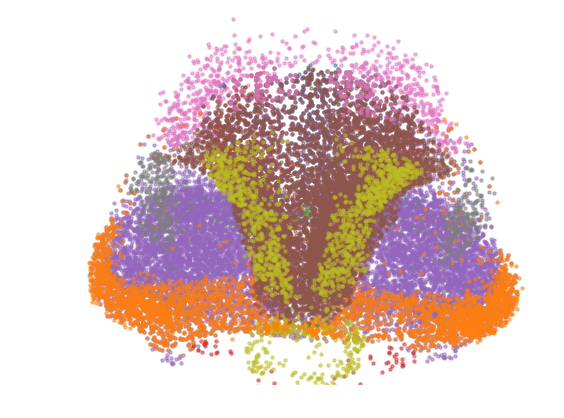

(170.0, 460.0, 1050.0, 1300.0)

In [73]:
df_avg = []

#rows,cols = 5,4
#figure(figsize=(cols*3,rows*5))
x = collect(1:n_frames)./fps

ctr = 1
sub = collect(1:length(tel_idx_list))
sub_list = tel_idx_list
for r = 1:length(sub)
    #subplot(rows,cols,r); axis("off"); title(sub_list[r])
    curr_region = tel_idx_list[r]
    idx = Int.(per_tel_regions[curr_region]["idx"])
    scatter(centroids[idx,2],centroids[idx,1],s=5,alpha=0.5)
    #idx2 = intersect(Int.(per_tel_regions[curr_region]["idx"]),sig_rois[11])
    #scatter(centroids[idx2,2],centroids[idx2,1],s=5,alpha=0.5,color="red")
end

ylim(1050,ymx)
xlim(170,460); axis("off")

In [43]:
per_tel_regions

Dict{String, Any} with 19 entries:
  "Olig2_Cluster"           => Dict{String, Any}("idx"=>[30.0; 87.0; … ; 184452…
  "Subpallial_Otpb_Cluster… => Dict{String, Any}("idx"=>[73.0; 132.0; … ; 17721…
  "Anterior_Commisure"      => Dict{String, Any}("idx"=>[128.0; 156.0; … ; 1731…
  "Isl1_cluster_2"          => Dict{String, Any}("idx"=>[250.0; 253.0; … ; 1742…
  "Pallium"                 => Dict{String, Any}("idx"=>[75.0; 133.0; … ; 18301…
  "Optic_Commissure"        => Dict{String, Any}("idx"=>Matrix{Float64}(undef, …
  "Olfactory_Bulb"          => Dict{String, Any}("idx"=>[34.0; 48.0; … ; 159531…
  "S1181t_Cluster"          => Dict{String, Any}("idx"=>[262.0; 319.0; … ; 1853…
  "Subpallial_Otpb_strip"   => Dict{String, Any}("idx"=>[817.0; 1139.0; … ; 177…
  "Postoptic_Commissure"    => Dict{String, Any}("idx"=>Matrix{Float64}(undef, …
  "Subpallial_Vglut2_Clust… => Dict{String, Any}("idx"=>[19697.0; 19735.0; … ; …
  "Vglut2_rind"             => Dict{String, Any}("idx"=>[75.0; 170.0; … ; 

In [42]:
tel_regions

LoadError: UndefVarError: tel_regions not defined

In [30]:
region_list



12-element Vector{Any}:
 "Thalamus"
 "Cerebellum"
 "Semicircularis"
 "Telencephalon"
 "Tectum"
 "Tegmentum"
 "Habenula"
 "Pretectum"
 "MON"
 "Hindbrain"
 "Raphe_Superior"
 "Interpeduncular_Nucleus"

In [23]:
region_names = ["Thalamus","Cerebellum","Semicircularis","Telencephalon","Tectum","Tegmentum"
 "Habenula"
 "Pretectum"
 "MON"
 "Hindbrain"
 "Raphe_Superior"
 "Interpeduncular_Nucleus"

LoadError: syntax: missing separator in array expression

In [194]:
r = 1
curr_region = region_list[r]
    idx = Int.(per_brain_regions[curr_region]["idx"])
    
    trace = mean(vec(DF[idx,:]),dims=2)

2026200-element Vector{Float64}:
 -0.03165116533637047
 -0.0095482487231493
 -0.03655372932553291
  0.020431114360690117
 -0.003528134897351265
 -0.01772439107298851
 -0.03202729672193527
 -0.028683822602033615
 -0.01888490654528141
  0.004467582330107689
  0.015897320583462715
 -0.012203192338347435
  0.016806701198220253
  ⋮
  0.0012126272777095437
  0.002899166662245989
 -0.0026628803461790085
 -0.004883091896772385
 -0.0033385097049176693
 -0.0067311665043234825
 -0.010358919389545918
 -0.006423104088753462
 -0.013053953647613525
  0.006035791244357824
  0.004944625310599804
 -0.004669466521590948

In [190]:
#rows,cols = 3,4
#figure(figsize=(cols*1.5,rows*2.5))
    df_avg = []
 
for r = 1:12
    curr_region = region_list[r]
    idx = Int.(per_brain_regions[curr_region]["idx"])
    
    df_avg = []
    for t in oddball_times
        df_resp = maximum(DF[idx,t:t+isi].-DF[idx,t])
       push!(df_avg,df_resp)
    end
    val = (mean(df_avg)./length(oddball_times))
    scatter(centroids[idx,2],centroids[idx,1],color=(0,0,val))
end

#for ax = [ax1,ax2,ax3]
#yticks(collect(1:12),region_list)
#xlim(0,0.002)

LoadError: PyError ($(Expr(:escape, :(ccall(#= /home/stednitz/.julia/packages/PyCall/L0fLP/src/pyfncall.jl:43 =# @pysym(:PyObject_Call), PyPtr, (PyPtr, PyPtr, PyPtr), o, pyargsptr, kw))))) <class 'TypeError'>
TypeError("object of type 'float' has no len()",)
  File "/usr/lib/python3/dist-packages/matplotlib/pyplot.py", line 3378, in scatter
    edgecolors=edgecolors, data=data, **kwargs)
  File "/usr/lib/python3/dist-packages/matplotlib/__init__.py", line 1718, in inner
    return func(ax, *args, **kwargs)
  File "/usr/lib/python3/dist-packages/matplotlib/axes/_axes.py", line 3913, in scatter
    mcolors.to_rgba_array(co)
  File "/usr/lib/python3/dist-packages/matplotlib/colors.py", line 231, in to_rgba_array
    result = np.empty((len(c), 4), float)


In [179]:
stimtimes

1×95 Matrix{Int64}:
 240  244  248  252  256  260  264  …  1076  1080  1084  1088  1092  1096

In [166]:
region_list

12-element Vector{Any}:
 "Thalamus"
 "Cerebellum"
 "Semicircularis"
 "Telencephalon"
 "Tectum"
 "Tegmentum"
 "Habenula"
 "Pretectum"
 "MON"
 "Hindbrain"
 "Raphe_Superior"
 "Interpeduncular_Nucleus"

In [158]:
mean(df_avg)

1842×1×5 Array{Float64, 3}:
[:, :, 1] =
 0.07729416396468877
 0.07729051159694791
 0.07028202228248119
 0.037357542244717476
 0.05831439250614494
 0.07387457108125091
 0.06918913684785366
 0.05809412132948637
 0.06942728944122792
 0.1311808118596673
 0.12742560170590878
 0.1077867366373539
 0.10761630143970251
 ⋮
 0.1459707200527191
 0.03647286384366453
 0.03025883175432682
 0.054582630703225735
 0.04221441317349672
 0.031563652912154794
 0.03680519311164972
 0.02363270618952811
 0.05848939224961214
 0.034002084843814374
 0.029535397328436373
 0.035054738027974965

[:, :, 2] =
 0.056610824167728425
 0.05250680819153786
 0.04565386150497943
 0.03293745534538175
 0.054906872753053906
 0.04741313392587472
 0.04261061688885093
 0.029528281837701797
 0.03465244797989726
 0.10190739405807107
 0.11013365499675273
 0.10762503147125244
 0.08939792662858963
 ⋮
 0.15366912120953202
 0.03191762533970177
 0.02809379664249718
 0.05867769399774261
 0.040120231173932555
 0.0347191650653258
 0.03584656

In [45]:
n_masks = size(masks)[1]

295

In [26]:
idx

80-element Vector{Float64}:
 945.0
 932.0
 954.0
 953.0
 946.0
 942.0
 948.0
 961.0
 951.0
 940.0
 959.0
 958.0
 943.0
   ⋮
  42.0
  47.0
  45.0
  48.0
  46.0
  49.0
  43.0
  44.0
  41.0
  39.0
  40.0
  38.0

In [34]:
region = 1
reg_name = masks[region,:][2]
coords = floor.(masks[region,:][3])

#idx = Int[ a == B[i,:] for i=1:size(B,1) ]

#idx = all(coords .== centroids, dims=2)
#idx = find(floor.(centroids) .== coords)#,dims=1)

inter = intersect(floor.(centroids), coords)
idx = (Int[findfirst(floor.(centroids), x) for x in inter], Int[findfirst(coords, x) for x in inter])


#scatter(centroids[idx,2],centroids[idx,3])

LoadError: MethodError: no method matching findfirst(::Matrix{Float64}, ::Float64)
[0mClosest candidates are:
[0m  findfirst(::AbstractArray) at ~/julia-1.7.2/share/julia/base/array.jl:1920
[0m  findfirst([91m::Function[39m, ::Any) at ~/julia-1.7.2/share/julia/base/array.jl:1994
[0m  findfirst(::Any) at ~/julia-1.7.2/share/julia/base/array.jl:1910

In [69]:
region = 1
reg_name = masks[region,:][2]
coords = floor.(masks[region,:][3])

for roi = 1:total_rois
    x,y,z = floor.(centroids[roi,1]),floor.(centroids[roi,2]),floor.(centroids[roi,3])
    idx = findall(coords .== Any[floor.(centroids[roi,:])]
    #print(length(idx))
    #dims = intersect(centroids, coords)
   # if (floor.(centroids[1,:]) in coords) == true
   #     print(reg_name)
    #end

end

In [49]:
curr_coord = [526.0,284.0,59.0]#coords[1,:]

3-element Vector{Float64}:
 526.0
 284.0
  59.0

In [75]:
region_names = [""]
for curr_reg in 1:n_masks
    region_name = masks[curr_reg,:][1]
    push!(region_names,region_name)
end
popfirst!(region_names)
region_names = unique(region_names)

6-element Vector{String}:
 "Diencephalon"
 "Ganglia"
 "Mesencephalon"
 "Rhombencephalon"
 "Spinal"
 "Telencephalon"

In [85]:
reg_name = masks[80,:][2]


"Facial glossopharyngeal ganglion"

In [118]:
ctr = 1
for region in [294,131,295]
    reg_name = masks[region,:][1]
    coords = floor.(masks[region,:][3])
    cx,cy,cz = coords[:,1],coords[:,2],coords[:,3]

    @time idx = intersect(findall(x1 -> x1 in cx,x),findall(x1 -> x1 in cy,y),findall(x1 -> x1 in cz,z))
    subplot(2,3,ctr)
    plt.hist2d(coords[:,2],coords[:,1])
    
    subplot(2,3,ctr+3)
    plt.hist2d(centroids[idx,2],centroids[idx,1])
    ctr+=1
end

LoadError: InterruptException:

In [136]:
valid_x = intersect(findall(x .> minimum(cx)), findall(x .< maximum(cx)))
valid_y = intersect(findall(y .> minimum(cy)), findall(y .< maximum(cy)))
valid_z = intersect(findall(z .> minimum(cz)), findall(z .< maximum(cz)))
valid_locs = intersect(valid_x,valid_y,valid_z)

@time for i =  1:size(coords)[1]
    curr_coord = coords[i,:]
    test = Ref(curr_coord == eachrow(floor.(centroids)))
end

#@time idx = intersect(findall(x1 -> x1 in cx,x[valid_locs]),findall(x1 -> x1 in cy,y[valid_locs]),findall(x1 -> x1 in cz,z[valid_locs]))


LoadError: InterruptException:

In [133]:
LocB = indexin(coords,centroids)

2035301×3 Matrix{Union{Nothing, CartesianIndex{2}}}:
 nothing                    nothing                   nothing
 nothing                    nothing                   nothing
 nothing                    nothing                   nothing
 nothing                    nothing                   nothing
 nothing                    nothing                   nothing
 nothing                    nothing                   nothing
 nothing                    nothing                   nothing
 nothing                    nothing                   nothing
 nothing                    nothing                   nothing
 nothing                    nothing                   nothing
 nothing                    nothing                   nothing
 nothing                    nothing                   nothing
 nothing                    nothing                   nothing
 ⋮                                                    
 CartesianIndex(161190, 1)  CartesianIndex(35043, 1)  nothing
 nothing                

LoadError: DimensionMismatch("arrays could not be broadcast to a common size; got a dimension with lengths 2035301 and 186675")

In [115]:
region = 1
coords = (floor.(masks[region,:][3]))

x,y,z = (floor.(centroids[:,1])),(floor.(centroids[:,2])),(floor.(centroids[:,3]))
cx,cy,cz = coords[:,1],coords[:,2],coords[:,3]

find_overlap(x,y,z,cx,cy,cz) = intersect(findall(x1 -> x1 in cx,x),findall(x1 -> x1 in cy,y),findall(x1 -> x1 in cz,z)) 

@time idx = intersect(findall(x1 -> x1 in cx,x),findall(x1 -> x1 in cy,y),findall(x1 -> x1 in cz,z))
@time idx = find_overlap(x,y,z,cx,cy,cz)

  1.368467 seconds (1.53 M allocations: 40.677 MiB, 17.78% compilation time)
  1.349913 seconds (909.38 k allocations: 44.678 MiB, 22.52% compilation time)


63-element Vector{Int64}:
  19753
  19801
  19951
  20221
  20395
  20515
  20553
  20635
  20989
  21026
  21417
  21621
  21752
      ⋮
 115066
 157151
 157275
 157612
 158274
 169936
 170088
 170124
 170165
 170181
 170424
 170668

In [ ]:
## thalamus, torus

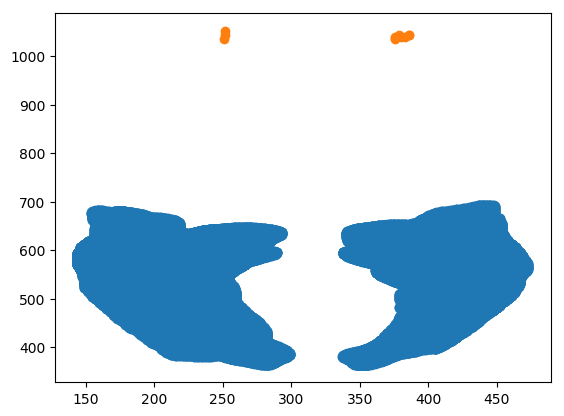

PyObject <matplotlib.collections.PathCollection object at 0x7f78aa854fd0>

In [106]:
idx = intersect(findall(x1 -> x1 in cx,x),findall(x1 -> x1 in cy,y),findall(x1 -> x1 in cz,z))


In [112]:
medians = vec(std(avgs[:,:,:],dims=2)[:,:,1])

3-element Vector{Float64}:
 196.61474019158902
 191.8633509937358
  40.74858242561291

In [108]:
minimum(avgs[3,:,1])

19.0